<a href="https://colab.research.google.com/github/MohammadRaziei/Deep-Learning-Course/blob/master/HW04/Q1/HW04_Q1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW04 : Problem 1

Please check last updates and get the latest version from following link. it is more completed but it may have some updates after release it.

[<img src="https://img.icons8.com/clouds/50/000000/github.png"/>](https://github.com/MohammadRaziei/Deep-Learning-Course/blob/master/)  
github link : https://github.com/MohammadRaziei/Deep-Learning-Course/blob/master/HW04

In [1]:
!pip install music21
!pip install bs4
!pip install pretty_midi

     |████████████████████████████████| 5.6MB 5.7MB/s 
     |████████████████████████████████| 61kB 4.1MB/s 
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-cp36-none-any.whl size=5591954 sha256=6dfee6922abc1854af2fa945e8b4614cd705827fd1bcd200b569d16453cdc9e4
  Stored in directory: /root/.cache/pip/wheels/4c/a1/c6/b5697841db1112c6e5866d75a6b6bf1bef73b874782556ba66
Successfully built pretty-midi


In [2]:
import os, shutil
def create_empty_folder(folder_name, recreate=True):
  try:
    if recreate:
      try: shutil.rmtree(folder_name)
      except: pass
    os.mkdir(folder_name)
    print('"%s" is created.'%folder_name)
  except Exception as e: # work on python 3.x
    print('Some error! : '+ str(e))

def create_empty_folders(folders_list):
  for folder in folders_list:
    create_empty_folder(folder)

In [3]:
from urllib.request import urlopen, urlretrieve
from bs4 import BeautifulSoup
import time
from tqdm.auto import trange


selected_instrument = 'Guitar'

# Define URL components
url_base = 'https://www.mutopiaproject.org/cgibin/make-table.cgi?startat={}&searchingfor=&Composer=&Instrument={}&Style=&collection=&id=&solo=&recent=&timelength=&timeunit=&lilyversion=&preview='

# Define save directory.
save_dir = 'guitar'
create_empty_folder(save_dir)

# Set initial values
songNumber = 0
linkCount = 10

lim = 10 
cnt = 0

# Locate and download each MIDI file
for cnt in trange(lim):
    cnt += 1
    url = url_base.format(songNumber, selected_instrument)
    html = urlopen(url)
    soup = BeautifulSoup(html.read())
    links = soup.find_all('a')
    linkCount = 0
    for link in links:
        href = link['href']
        if href.find('.mid') >= 0:
            linkCount = linkCount + 1
            urlretrieve(href, os.path.join(save_dir, "%d_%d.mid"%(cnt, linkCount)))
    if linkCount is 0: break
    songNumber += 10
    time.sleep(.1)

"guitar" is created.


## Part II

In [4]:
from music21 import converter, instrument
import os
from tqdm.auto import tqdm


save_dir = 'guitar'

# test that stream is monotonic or notr
def is_monophonic(stream):
    try:    length = len(instrument.partitionByInstrument(stream).parts)
    except: length = 0
    return length is 1

# Merge notes into chords
song_files = os.listdir(save_dir)
# data_scores = []
# for song_file in (song_files):
#   sng = converter.parse(os.path.join(save_dir,song_file))
#   if is_monophonic(sng): 
#     data_scores.append(sng)
data_scores = [sng.chordify() for song_file in tqdm(song_files) for sng in (converter.parse(os.path.join(save_dir,song_file)),) if is_monophonic(sng)]

print(len(data_scores))


88


In [5]:
from music21 import note, chord
from tqdm.auto import tqdm


data_chords = [[] for _ in data_scores]
data_durations = [[] for _ in data_scores]
data_keys = []

# Extract notes, chords, durations, and keys
for i, song in enumerate(tqdm(data_scores)):
  data_keys.append(str(song.analyze('key')))
  for element in song:
      if isinstance(element, note.Note):
          data_chords[i].append(element.pitch)
          data_durations[i].append(element.duration.quarterLength)
      elif isinstance(element, chord.Chord):
          data_chords[i].append('.'.join(str(n) for n in element.pitches))
          data_durations[i].append(element.duration.quarterLength)

In [6]:
from sklearn.preprocessing import LabelEncoder

chord_encoder = LabelEncoder()
chord_encoder.fit(sorted(list({*[subsub for sub in data_chords for subsub in sub]})))
num_unique_chords = len(chord_encoder.classes_)

duration_encoder = LabelEncoder()
duration_encoder.fit(sorted(list({*[subsub for sub in data_durations for subsub in sub]})))
num_unique_duration = len(duration_encoder.classes_)

print('number of unique chords: ', num_unique_chords)
print('10 instances of chords:', chord_encoder.classes_[0:10])
print()
print('number of unique duration: ', num_unique_duration)
print('unique durations:', [str(s) for s in duration_encoder.classes_])

number of unique chords:  3048
10 instances of chords: ['A1.C#4' 'A1.G3.A3.A4' 'A1.G3.A3.E4' 'A2' 'A2.A3' 'A2.A3.A4'
 'A2.A3.A4.A5' 'A2.A3.A4.D5' 'A2.A3.B-3' 'A2.A3.B3']

number of unique duration:  18
unique durations: ['1/12', '1/6', '0.25', '1/3', '5/12', '0.5', '2/3', '0.75', '5/6', '11/12', '1.0', '1.25', '17/12', '1.5', '2.0', '2.5', '3.0', '4.0']


In [7]:
from tqdm.auto import trange
import numpy as np

sequence_length = 32

# Define empty array for train data
train_chords = [];  train_durations = []
target_chords = []; target_durations = []

# Construct train and target sequences for chords and durations
for i in trange(len(data_chords)):
    chord_list = chord_encoder.transform(data_chords[i])
    duration_list = duration_encoder.transform(data_durations[i])
    for t in range(len(chord_list) - sequence_length):
        train_chords.append(chord_list[t:t+sequence_length])
        target_chords.append(chord_list[t+1])

        train_durations.append(duration_list[t:t+sequence_length])
        target_durations.append(duration_list[t+1])


train_chords = np.array(train_chords);    train_durations = np.array(train_durations)
target_chords = np.array(target_chords);  target_durations = np.array(target_durations)

num_samples, num_chords = train_chords.shape
# num_durations = train_durations.shape[1]


In [8]:
from tensorflow.keras.utils import to_categorical

target_chords_1hot = to_categorical(target_chords)
target_durations_1hot = to_categorical(target_durations)

## Part III

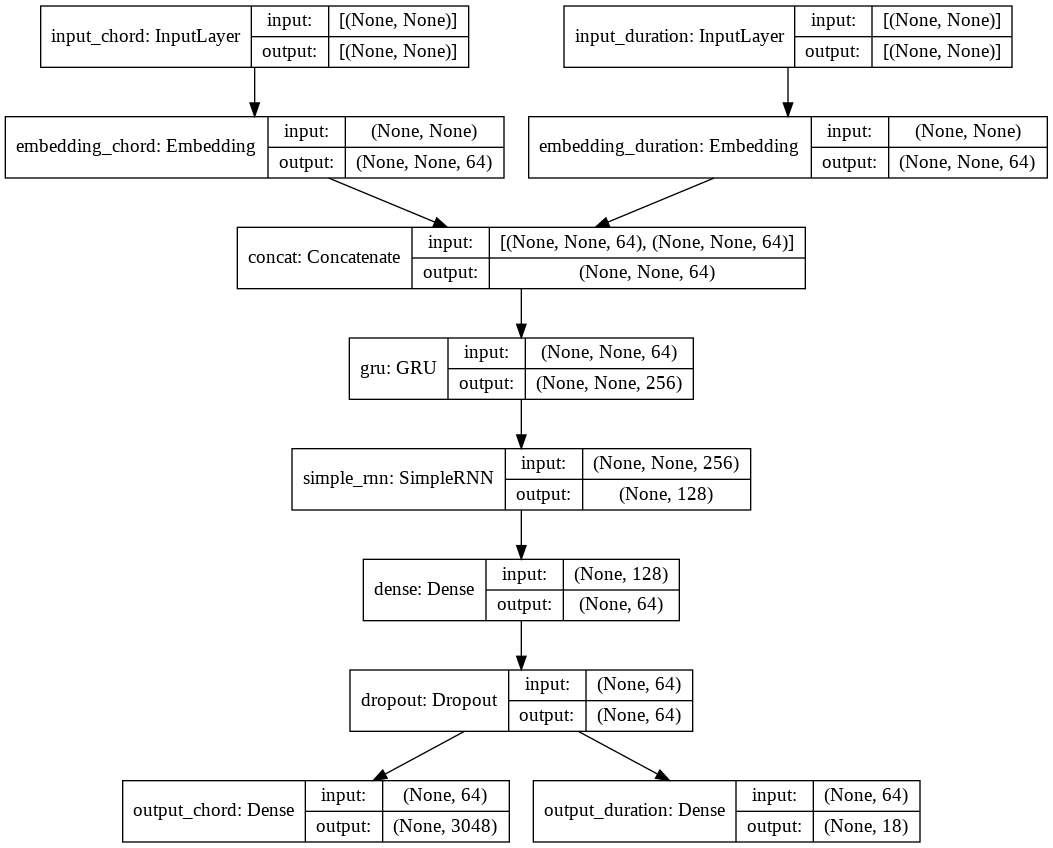

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_chord (InputLayer)        [(None, None)]       0                                            
__________________________________________________________________________________________________
input_duration (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_chord (Embedding)     (None, None, 64)     195072      input_chord[0][0]                
__________________________________________________________________________________________________
embedding_duration (Embedding)  (None, None, 64)     1152        input_duration[0][0]             
______________________________________________________________________________________________

In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.layers import Embedding, Concatenate, GRU, SimpleRNN
from tensorflow.keras.models import Model
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import plot_model
from IPython.display import display, Image

# Use Keras Functional API for using Concatenate layer

# Define inputs
input_chord = Input(shape = (None,), name='input_chord')
input_duration = Input(shape = (None,), name='input_duration')

# Define embedding layers:
embed_dim = 64
sequence_length = 32
embedding_chord = Embedding(num_unique_chords, embed_dim, input_length = sequence_length, name='embedding_chord')(input_chord)
embedding_duration = Embedding(num_unique_duration, embed_dim, input_length = sequence_length, name='embedding_duration')(input_duration)

# Concatenation the embedding layers:
concat = Concatenate(axis=1, name='concat')([embedding_chord, embedding_duration])
# GRU and SimpleRNN:
gru = GRU(256, return_sequences=True, name='gru')(concat)
simple_rnn = SimpleRNN(128, name='simple_rnn')(gru)
dense = Dense(64, activation='relu', name='dense')(simple_rnn)

dropout = Dropout(0.3, name='dropout')(dense) 
# Define outputs:
output_chord = Dense(target_chords_1hot.shape[1], activation = 'softmax', name='output_chord')(dropout)
output_duration = Dense(target_durations_1hot.shape[1], activation = 'softmax', name='output_duration')(dropout)

# Define model:
model = Model(inputs = [input_chord, input_duration], outputs = [output_chord, output_duration], name='model')
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
plot_model(model, show_shapes=True); display(Image('model.png'))
model.summary()

In [10]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10748611995551403372
]


## Part IV

In [ ]:
train_data = [train_chords, train_durations]
target_data = [target_chords_1hot, target_durations_1hot]
history = model.fit(train_data, 
          target_data, 
          epochs=80, 
          batch_size=256
          )
model.save('simplemodel_chord_duration.h5')

Epoch 1/80
122/122 [==============================] - 85s 675ms/step - loss: 8.3610 - output_chord_loss: 7.1680 - output_duration_loss: 1.1929 - output_chord_accuracy: 0.0126 - output_duration_accuracy: 0.6936
Epoch 2/80
122/122 [==============================] - 78s 637ms/step - loss: 6.7474 - output_chord_loss: 6.1461 - output_duration_loss: 0.6013 - output_chord_accuracy: 0.0234 - output_duration_accuracy: 0.8088
Epoch 3/80
122/122 [==============================] - 78s 639ms/step - loss: 6.3934 - output_chord_loss: 5.9694 - output_duration_loss: 0.4240 - output_chord_accuracy: 0.0229 - output_duration_accuracy: 0.8652
Epoch 4/80
122/122 [==============================] - 78s 641ms/step - loss: 6.1989 - output_chord_loss: 5.8800 - output_duration_loss: 0.3189 - output_chord_accuracy: 0.0248 - output_duration_accuracy: 0.8994
Epoch 5/80
122/122 [==============================] - 80s 655ms/step - loss: 6.0338 - output_chord_loss: 5.8219 - output_duration_loss: 0.2119 - output_chord_ac

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))

plt.subplot(121)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['output_chord_loss'], label='Chord loss')
plt.plot(history.history['output_duration_loss'], label='Duration loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(history.history['output_chord_accuracy'], label='Chord accuracy')
plt.plot(history.history['output_duration_accuracy'], label='Duration accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
import numpy as np
from tqdm.auto import trange

initial_chords = train_chords[0:1]
initial_durations = train_durations[0:1]

def predict(chords, durations):
    pred_chords, pred_durations = model.predict([chords, durations])
    return np.argmax(pred_chords), np.argmax(pred_durations)

# empty lists for generated chords and durations
generated_chords = []; generated_durations = []

# Generate chords and durations
num_iter = 50
for j in trange(num_iter):
    gen_chord, gen_duration = predict(initial_chords, initial_durations)
    generated_chords.append(gen_chord)
    generated_durations.append(gen_duration)
    # shift chords and durations and append new data at last
    initial_chords[0][:-1] = initial_chords[0][1:]
    initial_chords[0][-1] = gen_chord
    initial_durations[0][:-1] = initial_durations[0][1:]
    initial_durations[0][-1] = gen_duration
    
# change to numpy ndarray:
generated_chords = np.array(generated_chords)
generated_durations = np.array(generated_durations) 



In [ ]:
from music21 import instrument, stream, note, chord
from tqdm.auto import trange
import os

# Define save directory
generated_folder = 'generated'
create_empty_folder(generated_folder)

# Create stream object and add guitar as instrument
generated_stream = stream.Stream()
generated_stream.append(instrument.Guitar())

# Add notes and durations to stream
for i in trange(generated_chords.shape[0]):
    chord_str = chord_encoder.inverse_transform([generated_chords[i]])[0]
    chord_str = chord_str.replace('.', ' ')
    try:
        generated_stream.append(note.Note(chord_str, quarterType = generated_durations[j]))
    except:
        generated_stream.append(chord.Chord(chord_str, quarterType = generated_durations[j]))

# Save as MIDI file
generated_stream.write('midi', fp=os.path.join(generated_folder,'generated-simplemodel.mid'))


## Part V

## Part VII

In [ ]:
from tensorflow.keras.layers import Input, Embedding, Concatenate, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import plot_model
from IPython.display import display, Image

# Define inputs:
input_chord = Input(shape = (None,), name='input_chord')
input_duration = Input(shape = (None,), name='input_duration')

# Define embedding layers:
embedding_chord = Embedding(num_unique_chords, embed_dim, input_length = sequence_length, name='embedding_chord')(input_chord)
embedding_duration = Embedding(num_unique_duration, embed_dim, input_length = sequence_length, name='embedding_duration')(input_duration)

# Concatenate embedding layers:
concat = Concatenate(axis=1, name='concat')([embedding_chord, embedding_duration])

# Define LSTM layer
lstm = LSTM(512, name='lstm')(concat)

# Define dense layer
dense = Dense(256, name='dense')(lstm)

# Define output layers
output_chord = Dense(target_chords_1hot.shape[1], activation = 'softmax', name='output_chord')(dense)
output_duration = Dense(target_durations_1hot.shape[1], activation = 'softmax', name='output_duration')(dense)

# Define model
model = Model(inputs = [input_chord, input_duration], outputs = [output_chord, output_duration], name='lstm_model')
model.compile(loss=CategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])
plot_model(model, to_file='lstm_model.png', show_shapes=True); display(Image('lstm_model.png'))
model.summary()

In [ ]:
train_data = [train_chords, train_durations]
target_data = [target_chords_1hot, target_durations_1hot]
history = model.fit(train_data, 
          target_data, 
          epochs=128, 
          batch_size=256
          )
model.save('lstmModel_chord_duration.h5')

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))

plt.subplot(121)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['output_chord_loss'], label='Chord loss')
plt.plot(history.history['output_duration_loss'], label='Duration loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(history.history['output_chord_accuracy'], label='Chord accuracy')
plt.plot(history.history['output_duration_accuracy'], label='Duration accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
import numpy as np
from tqdm.auto import trange

initial_chords = train_chords[0:1]
initial_durations = train_durations[0:1]

def predict(chords, durations):
    pred_chords, pred_durations = model.predict([chords, durations])
    return np.argmax(pred_chords), np.argmax(pred_durations)

# empty lists for generated chords and durations
generated_chords = []; generated_durations = []

# Generate chords and durations
num_iter = 90
for j in trange(num_iter):
    gen_chord, gen_duration = predict(initial_chords, initial_durations)
    generated_chords.append(gen_chord)
    generated_durations.append(gen_duration)
    # shift chords and durations and append new data at last
    initial_chords[0][:-1] = initial_chords[0][1:]
    initial_chords[0][-1] = gen_chord
    initial_durations[0][:-1] = initial_durations[0][1:]
    initial_durations[0][-1] = gen_duration
    
# change to numpy ndarray:
generated_chords = np.array(generated_chords)
generated_durations = np.array(generated_durations) 



In [ ]:
from music21 import instrument, stream, note, chord
from tqdm.auto import trange
import os

# Define save directory
generated_folder = 'generated'
create_empty_folder(generated_folder)

# Create stream object and add guitar as instrument
generated_stream = stream.Stream()
generated_stream.append(instrument.Guitar())

# Add notes and durations to stream
for i in trange(generated_chords.shape[0]):
    chord_str = chord_encoder.inverse_transform([generated_chords[i]])[0]
    chord_str = chord_str.replace('.', ' ')
    try:
        generated_stream.append(note.Note(chord_str, quarterType = generated_durations[j]))
    except:
        generated_stream.append(chord.Chord(chord_str, quarterType = generated_durations[j]))

# Save as MIDI file
generated_stream.write('midi', fp=os.path.join(generated_folder,'generated-lstm_model.mid'))
